In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'simple_7'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')
model_folder = os.path.join(folder, 'model')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# if not os.path.isfile(merge_file):
#     dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
#     df = pd.concat(dfs)
#     df.to_parquet(merge_file)
# else:
#     df = pd.read_parquet(merge_file)
dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
df = pd.concat(dfs)

In [3]:
df.columns

Index(['eps', 'gamma', 'lr', 'memory_episodes', 'target_update_freq', 'job_id',
       'round_number', 'sampling', 'update_step', 'metric', 'value'],
      dtype='object')

In [4]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value', 'job_id']

labels = [c for c in df.columns if c not in non_labels]


In [5]:
df['metric'].unique()

array(['punishments', 'contributions', 'common_good',
       'contributor_payoff', 'manager_payoff', 'next_reward', 'q_min',
       'q_max', 'q_mean', 'loss'], dtype=object)

In [18]:
import statsmodels.formula.api as smf
w = (
    (df['metric'] == 'common_good') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

for l in labels:
    dfs[l] = dfs[l].astype(str)


label_ref = {
    'eps': '0.1',
    'gamma': '1.0',
    'lr': '3.e-4',
    'memory_episodes': '100',
    'target_update_freq': '100',
}


label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]


results = smf.glm(f"value ~ {'+'.join(label_str)}", data=dfs).fit()
results_df = results.summary2().tables[1]

# print('metric accuracy - positive coef -> better')
# results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')
results_df

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,21.985419,0.100204,219.406455,0.000000,21.789023,22.181815
"C(eps, Treatment(reference='0.1'))[T.0.2]",0.047815,0.075747,0.631249,0.527877,-0.100646,0.196277
"C(gamma, Treatment(reference='1.0'))[T.0.5]",0.163430,0.092771,1.761646,0.078129,-0.018398,0.345257
"C(gamma, Treatment(reference='1.0'))[T.0.8]",-0.092737,0.092771,-0.999638,0.317486,-0.274565,0.089090
"C(lr, Treatment(reference='3.e-4'))[T.1.e-4]",0.058785,0.075747,0.776068,0.437709,-0.089677,0.207247
"C(memory_episodes, Treatment(reference='100'))[T.1000]",-0.045533,0.075747,-0.601113,0.547765,-0.193994,0.102929
"C(target_update_freq, Treatment(reference='100'))[T.20]",0.046307,0.075747,0.611334,0.540978,-0.102155,0.194769


In [19]:
label_str

["C(eps, Treatment(reference='0.1'))",
 "C(gamma, Treatment(reference='1.0'))",
 "C(lr, Treatment(reference='3.e-4'))",
 "C(memory_episodes, Treatment(reference='100'))",
 "C(target_update_freq, Treatment(reference='100'))"]

In [16]:
df['target_update_freq'].unique()

array([100,  20])

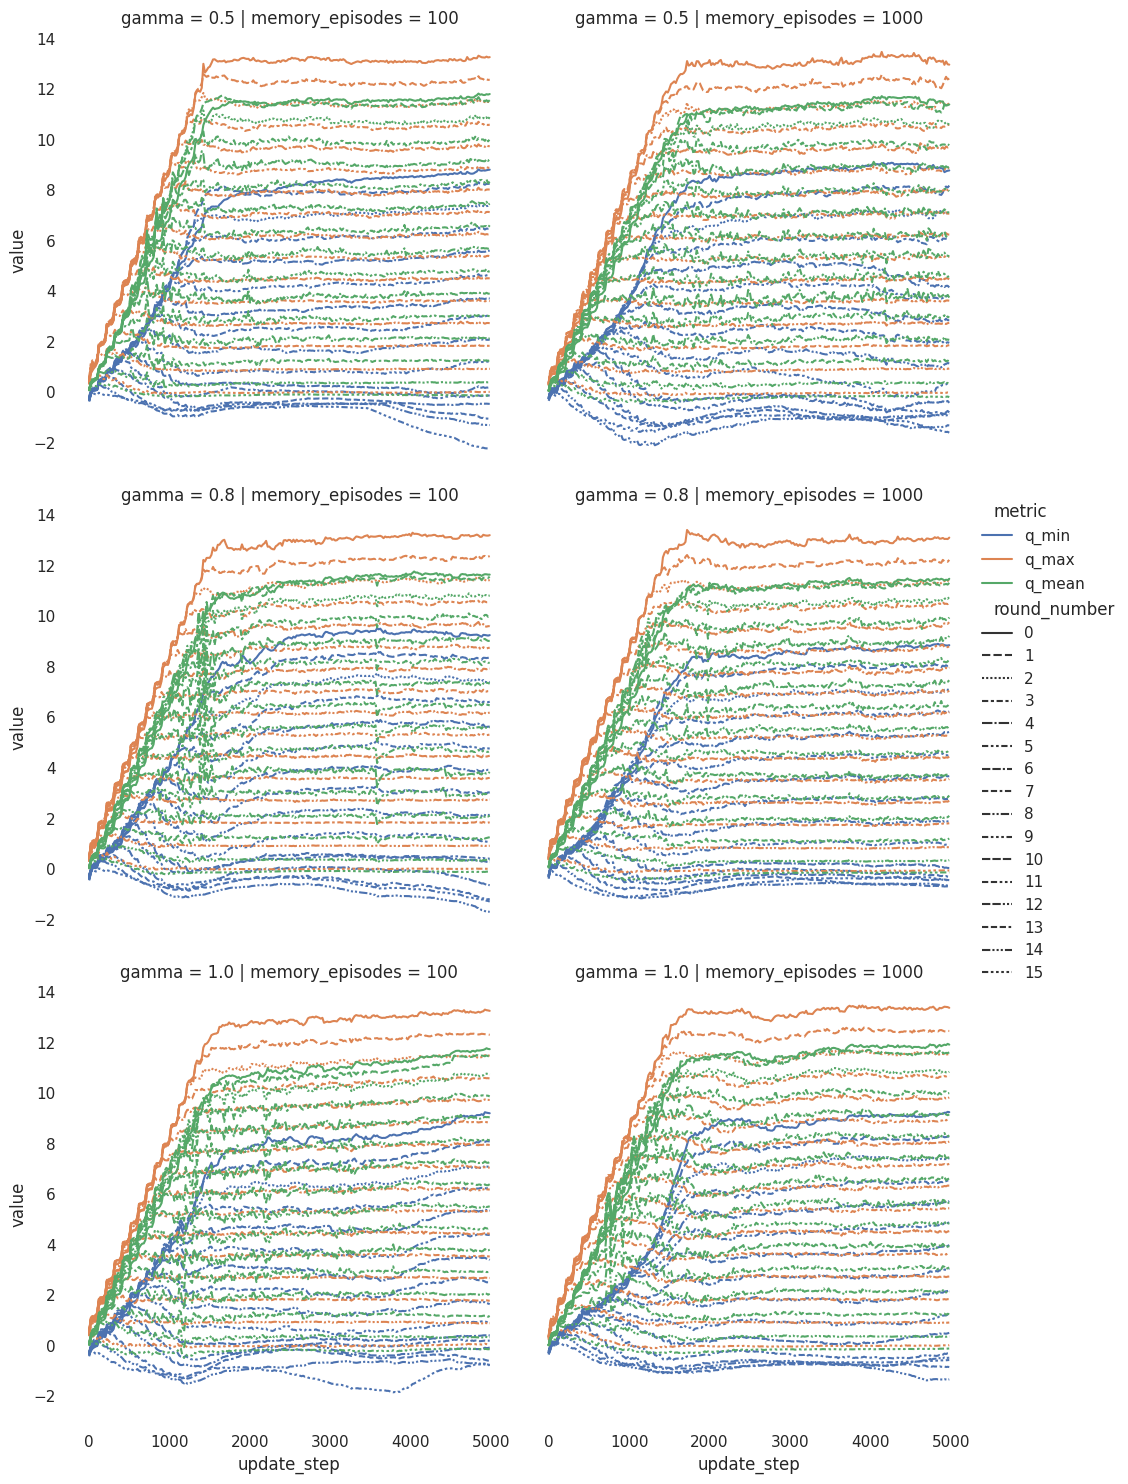

In [23]:
selection = {'eps': 0.2, 'gamma': 0.5, 'lr': '1.e-4', 'metric': 'next_reward', 'memory_episodes': 100, 'sampling': 'greedy', 'target_update_freq': 20}

focus = ['update_step', 'metric', 'round_number', 'memory_episodes', 'gamma']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

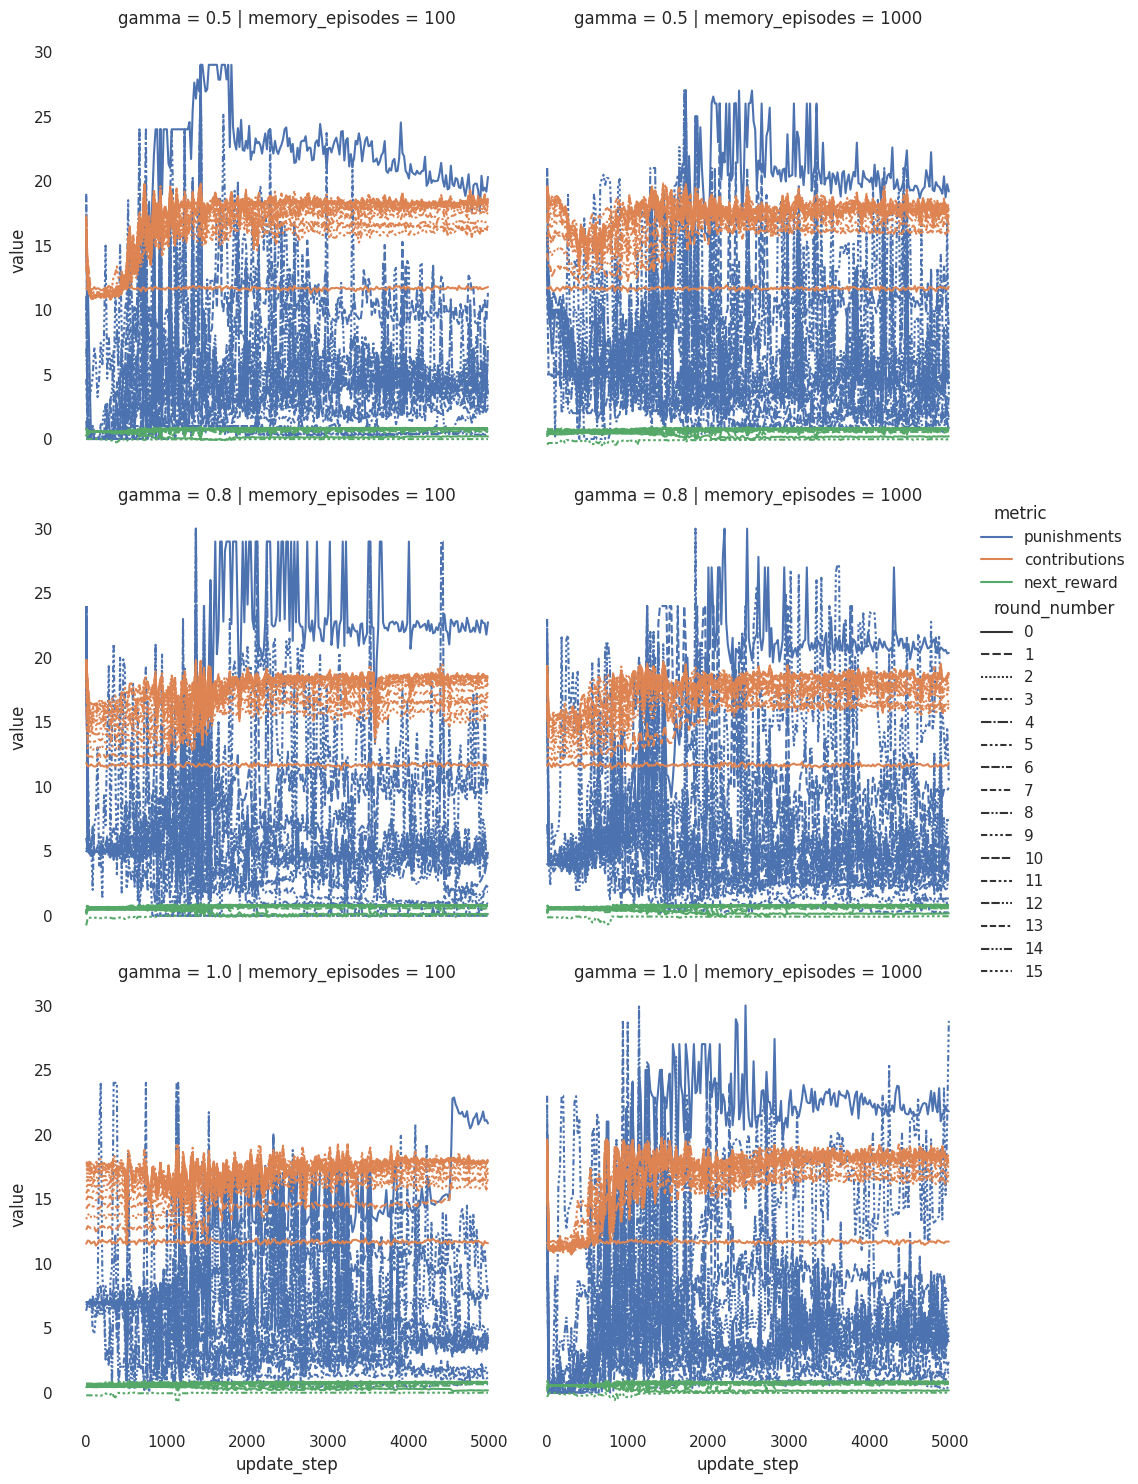

In [22]:
focus = ['update_step', 'metric', 'round_number', 'memory_episodes', 'gamma']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'next_reward'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))


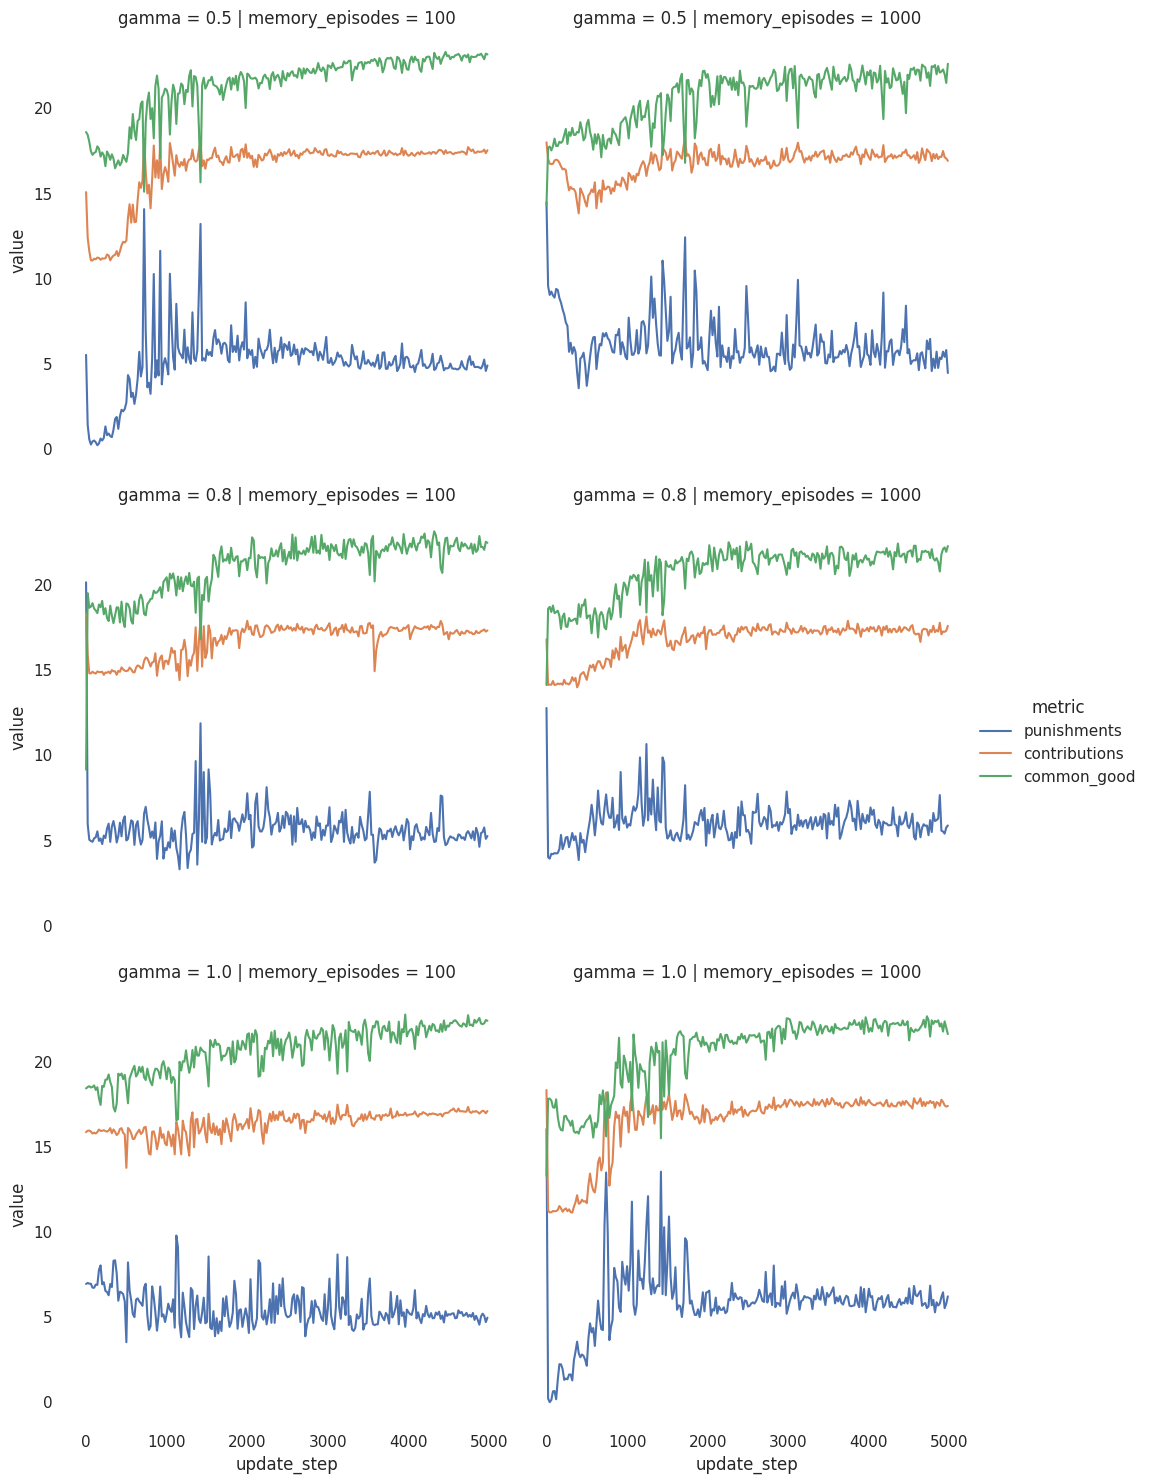

In [24]:
focus = ['update_step', 'metric', 'memory_episodes', 'gamma']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))

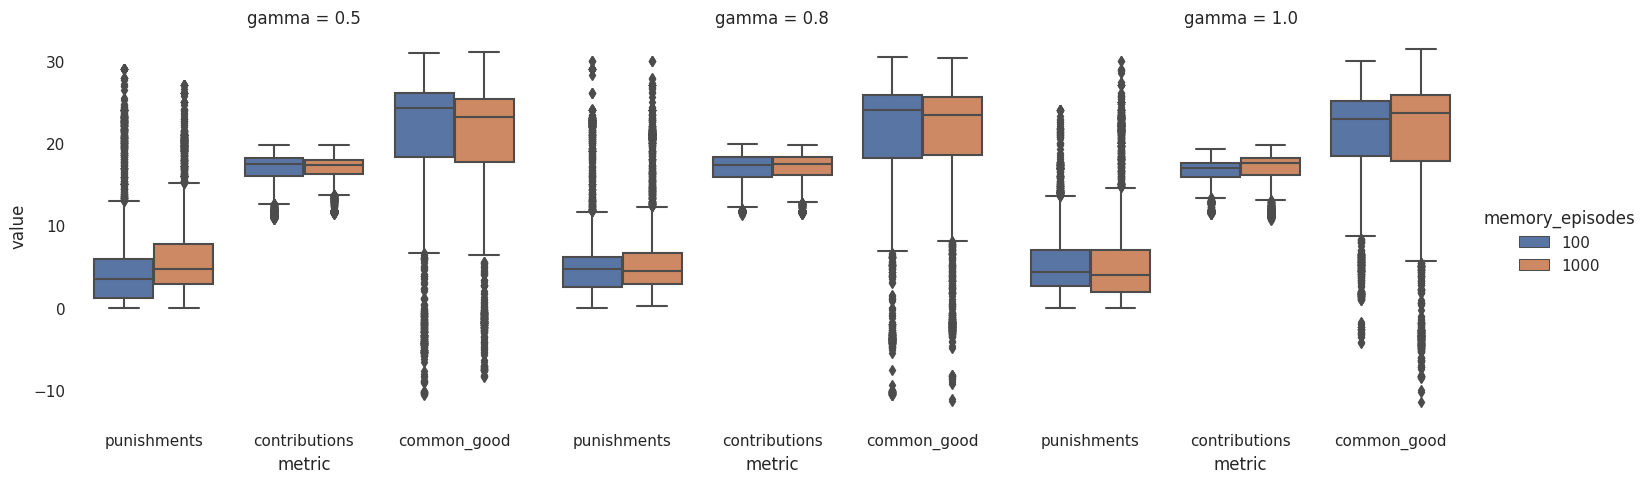

In [25]:
focus = ['metric', 'memory_episodes', 'gamma']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()


# dfs = dfs[dfs['update_step'] > 4000]

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.catplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))

In [26]:
import os
import torch as th
import numpy as np
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.environment_v3 import ArtificialHumanEnv
from aimanager.manager.manager import ArtificalManager

device = th.device('cpu')

n_episodes = 1000

class RuleHuman():
    def __init__(self, contribution):
        self.contribution = contribution

    def encode_pure(self, data, **kwargs):
        return data

    def predict_pure(self, data, **kwargs):
        return th.full_like(data['prev_contributions'], fill_value=self.contribution), 


job_id = df.iloc[0]['job_id']
model_file = os.path.join(model_folder, f'{job_id}.parquet')
rec_keys = ['punishments', 'contributions', 'common_good', 'contributor_payoff', 'manager_payoff']
metric_list = []

for c in range(0,20):
    human_rule_args = {
        'contribution': c
    }

    ah = RuleHuman(**human_rule_args)
    manager = ArtificalManager.load(model_file, device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, default_values=manager.default_values, n_agents=4, n_contributions=21, n_punishments=31, batch_size=n_episodes, n_rounds=16, device=device)

    state = env.reset()
    for round_number in count():
        action = manager.get_punishment(**state, **env.get_batch_structure())
        state = env.punish(action)
        
        metrics = {
            k: state[k].to(th.float).mean().item() for k in rec_keys}
        
        metrics = {**metrics, **human_rule_args, 'manager': job_id}

        # pass actions to environment and advance by one step
        state, reward, done = env.step()

        metrics['next_reward'] = reward.mean().item()
        metrics['round_number'] = round_number
        metric_list.append(metrics)
        # break
        if done:
            break

# df.to_parquet(os.path.join(output_path, f'metrics.parquet'))

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [27]:
id_vars = ['round_number', 'manager'] + list(human_rule_args.keys())

dfm = pd.DataFrame.from_records(metric_list)

value_vars = list(set(dfm.columns) - set(id_vars))
dfm = dfm.melt(id_vars=id_vars, value_vars=value_vars, var_name='metric')

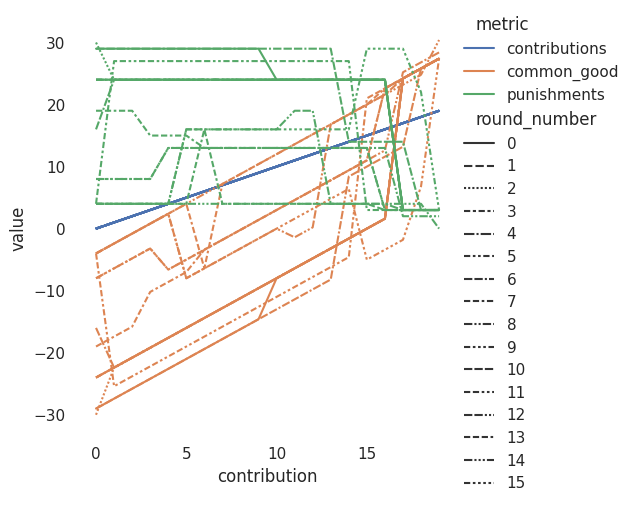

In [28]:
selection = {}

focus = ['contribution', 'metric', 'round_number']

dfs = dfm.copy()

if len(selection):
    w = pd.concat(
        (dfs[k] == v
        for k,v in selection.items() if (k not in focus) and (k in dfs.columns)
        ), axis=1
    ).all(1)
    dfs = dfs[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))

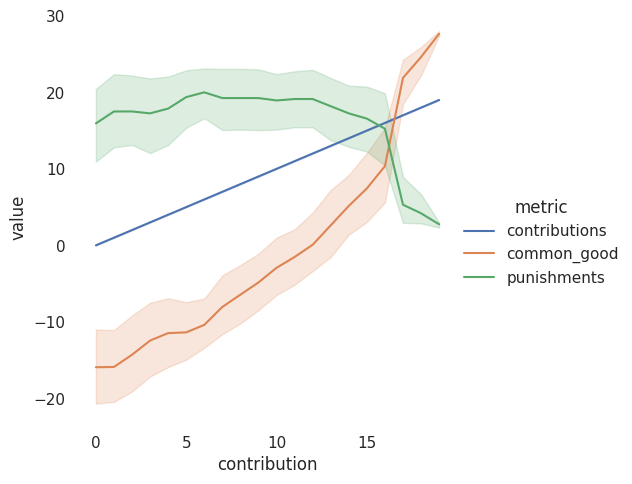

In [30]:
selection = {}

focus = ['contribution', 'metric']

dfs = dfm.copy()

if len(selection):
    w = pd.concat(
        (dfs[k] == v
        for k,v in selection.items() if (k not in focus) and (k in dfs.columns)
        ), axis=1
    ).all(1)
    dfs = dfs[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line')

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))